In [29]:
%reload_ext autoreload
%autoreload 2
    
from tqdm import tqdm

import torch
import torch.nn as nn
from matplotlib import pyplot as plt

import tasks
import models

In [35]:
# Hyperparameters
B = 300 # Batch size
D = 10 # Input dimensions
N = 50 # Number of recurrent neurons
learning_rate = 1e-2
num_epochs = 3600

start_sigma = 0.1
end_sigma = 0.5
sigma = torch.cat((
    start_sigma*torch.ones(num_epochs//3), 
    torch.linspace(start_sigma, end_sigma, num_epochs//3),
    end_sigma*torch.ones(num_epochs//3)
))

start_delay = 1
end_delay = 10
delay_time = torch.cat((
    start_delay * torch.ones(num_epochs//3, dtype=torch.int),
    torch.linspace(start_delay, end_delay, num_epochs//3, dtype=torch.int),
    end_delay*torch.ones(num_epochs//3, dtype=torch.int)
))
task = tasks.GoNogo(D, sigma, delay_time=1)

# Create network
net = models.GainRNN(task.input_dimensionality(), N, task.output_dimensionality(), input_rank=3, recurrent_rank=1)

loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

save_accuracy = torch.zeros(num_epochs)

# Training loop
for epoch in range(num_epochs):
    X, target, params = task.generate_data(B, sigma=sigma[epoch], delay_time=delay_time[epoch], source_strength=1.0, source_floor=0.5)

    optimizer.zero_grad()
    outputs, hidden = net(X, return_hidden=True)
    loss = loss_function(outputs, target)
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % (num_epochs // 10) == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [360/3600], Loss: 0.0409
Epoch [720/3600], Loss: 0.0406
Epoch [1080/3600], Loss: 0.0411
Epoch [1440/3600], Loss: 0.0000
Epoch [1800/3600], Loss: 0.0000
Epoch [2160/3600], Loss: 0.0000
Epoch [2520/3600], Loss: 0.0253
Epoch [2880/3600], Loss: 0.0292
Epoch [3240/3600], Loss: 0.0248
Epoch [3600/3600], Loss: 0.0230


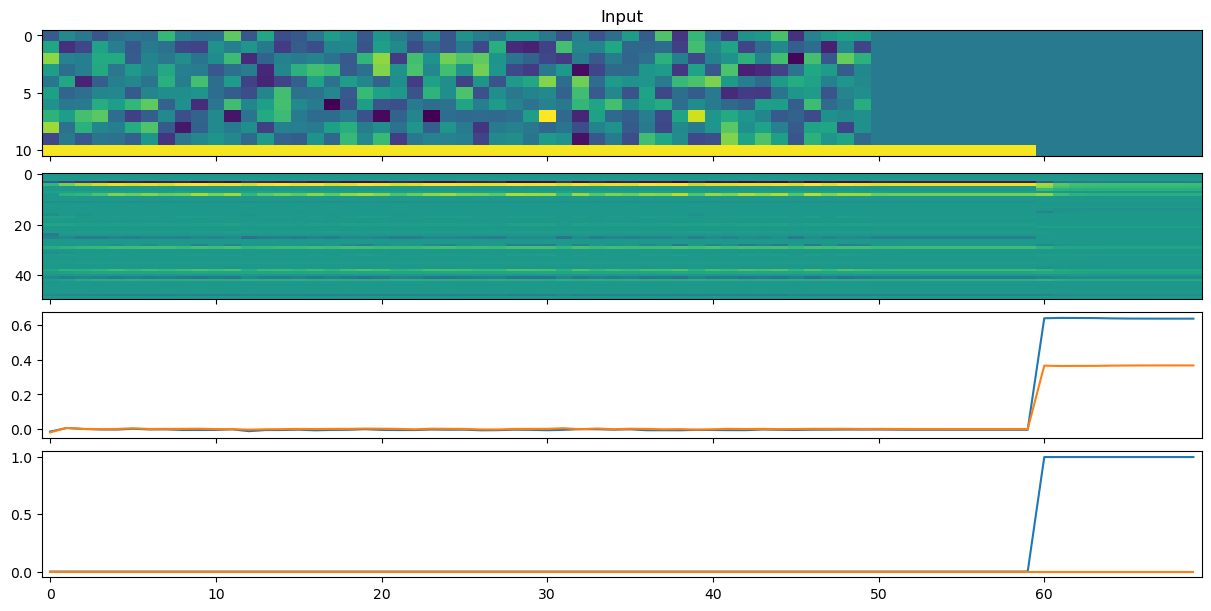

In [36]:
ibatch = 0

fig, ax = plt.subplots(4, 1, figsize=(12, 6), layout="constrained", sharex=True)
ax[0].imshow(X[ibatch].T, aspect="auto")
ax[0].set_title("Input")
ax[1].imshow(hidden[ibatch].detach().numpy().T, aspect="auto", interpolation="none")
ax[2].plot(outputs[ibatch].detach().numpy(), label="Output")
ax[3].plot(target[ibatch].detach().numpy(), label="Target")
plt.show()

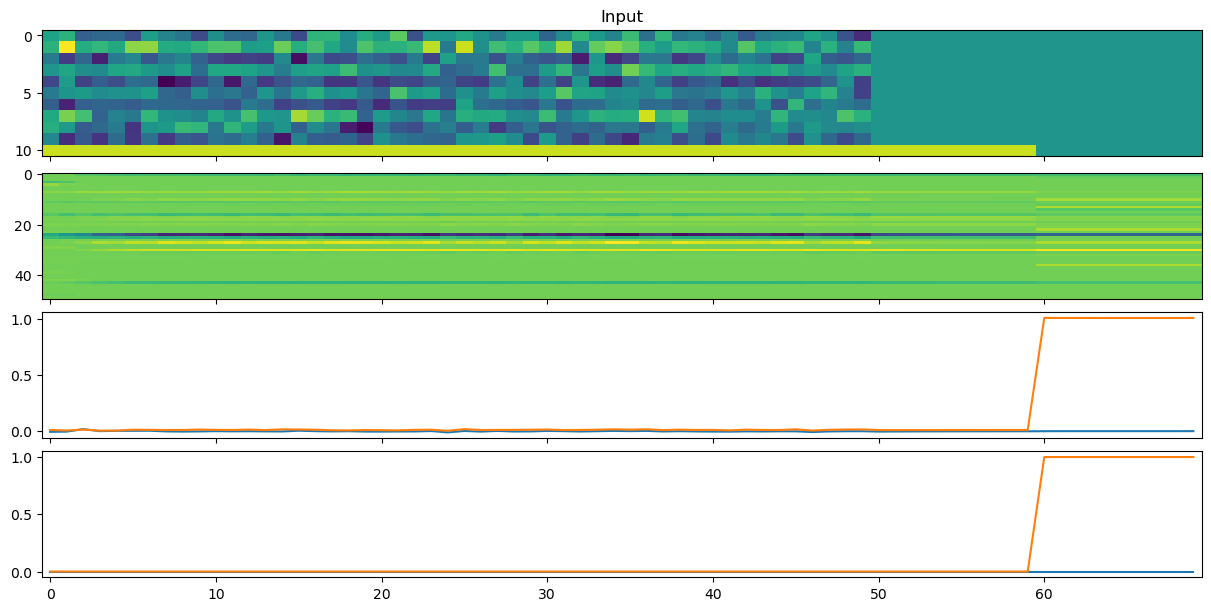

In [38]:
ibatch = 1

fig, ax = plt.subplots(4, 1, figsize=(12, 6), layout="constrained", sharex=True)
ax[0].imshow(X[ibatch].T, aspect="auto")
ax[0].set_title("Input")
ax[1].imshow(hidden[ibatch].detach().numpy().T, aspect="auto", interpolation="none")
ax[2].plot(outputs[ibatch].detach().numpy(), label="Output")
ax[3].plot(target[ibatch].detach().numpy(), label="Target")
plt.show()

In [6]:
params["s_empirical"][:10]

tensor([-0.0974,  0.0866, -0.0177,  0.0962, -0.0976, -0.0620, -0.0904,  0.0902,
         0.0977, -0.0929])

Beta: Parameter containing:
tensor(0.8745, requires_grad=True) Alpha: Parameter containing:
tensor([0.6411, 0.8757], requires_grad=True)
torch.Size([11, 2]) torch.Size([2, 2])


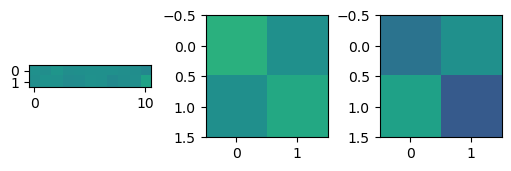

In [54]:
ipweight = net.input_weight.weight.detach().T
rcweight = net.recurrent_weight.weight.detach()
roweight = net.readout.weight.detach()
sd_score = roweight[0] - roweight[1]
isort = torch.argsort(sd_score)

print("Beta:", net.rnn.beta, "Alpha:", net.rnn.alpha)
print(ipweight.shape, rcweight.shape)

fig, ax = plt.subplots(1, 3, figsize=(5, 4), layout="constrained")
ax[0].imshow(ipweight.T[isort], vmin=-1, vmax=1)
ax[1].imshow(rcweight.T[isort][:, isort], vmin=-1, vmax=1)
ax[2].imshow(roweight.T[isort], vmin=-1, vmax=1)
plt.show()

In [44]:
ipweight.T

tensor([[-3.0019e-03,  8.0061e-03, -4.9607e-04, -7.6670e-03, -1.8169e-02,
          1.4057e-02, -5.0839e-03, -1.8974e-02,  3.1144e-03, -1.9640e-03,
          3.6878e-01],
        [ 9.8980e-04, -1.1440e-02, -8.7633e-04, -2.0143e-05, -2.5359e-03,
         -3.1783e-06, -3.8885e-02,  9.0732e-03, -1.1556e-05, -1.2034e-02,
          2.1957e-02]])

In [7]:
X, labels, params = task.generate_data(B)
outputs, spks, mems = net(X, start_integration=start_integration)
choice = torch.argmax(outputs, dim=1)

torch.cat((params["stimuli"][:10], labels[:10].unsqueeze(1), choice[:10].unsqueeze(1)), dim=1)

TypeError: ContextualGoNogo.generate_data() missing 1 required positional argument: 'T'

In [ ]:
ibatch = 8

print(X[ibatch].shape, spks[ibatch].shape, mems[ibatch].shape)

fig, ax = plt.subplots(3, 1, figsize=(9, 6), layout="constrained")
ax[0].imshow(X[ibatch].T, aspect="auto")
ax[1].imshow(spks[ibatch][:, isort].detach().T, aspect="auto")
ax[2].imshow(mems[ibatch][:, isort].detach().T, aspect="auto")
plt.show()